# Data Analysis

In [104]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import pytz

In [122]:
#Full Final CSV Files
rainfall =pd.read_csv("../data/final_data/Rainfall.csv")
air_temperature = pd.read_csv("../data/final_data/Air Temp.csv")
wind_speed = pd.read_csv("../data/final_data/Wind Speed.csv")
relative_humidity = pd.read_csv("../data/final_data/Humidity.csv")
lightning_risk_16S = pd.read_csv("../data/final_data/Lightning Risk 16S.csv") # Output
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity]

In [107]:
station_ids=['S100', 'S104', 'S106', 'S107', 'S108', 'S109', 'S111', 'S115', 'S116', 'S117', 'S121', 'S24', 'S43', 'S44', 'S50', 'S60']

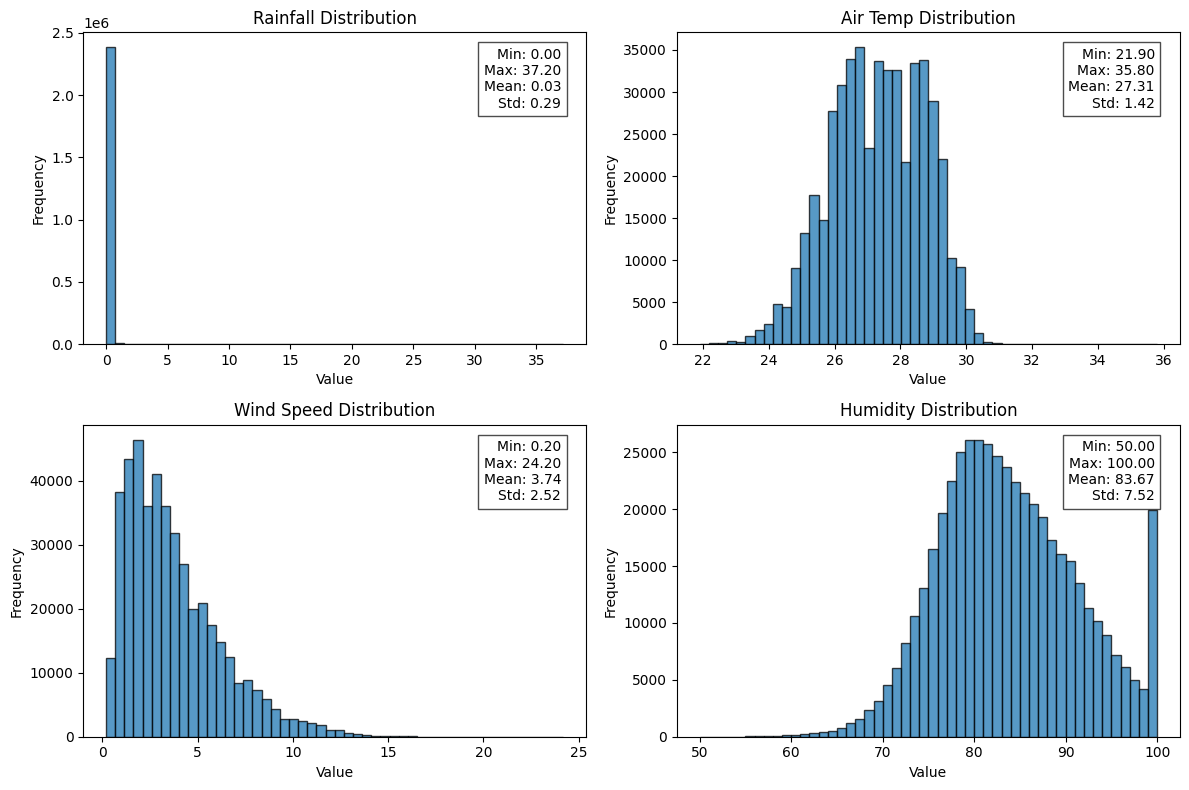

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

# List of dataframes
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity]
df_names = ["Rainfall", "Air Temp", "Wind Speed", "Humidity"]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten for easy iteration

for i, (df, name) in enumerate(zip(input_data_dfs, df_names)):
    # Select only numerical columns (excluding Timestamp)
    df_values = df.drop(columns=["Timestamp"], errors="ignore").melt().value.dropna()
    
    # Convert to float
    df_values = df_values.astype(float)
    # Calculate statistics
    min_val = df_values.min()
    max_val = df_values.max()
    mean_val = df_values.mean()
    std_val = df_values.std()

    # Plot histogram
    axes[i].hist(df_values, bins=50, alpha=0.75, edgecolor="black")
    axes[i].set_title(f"{name} Distribution")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    stats_text = f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}\nStd: {std_val:.2f}"
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show()

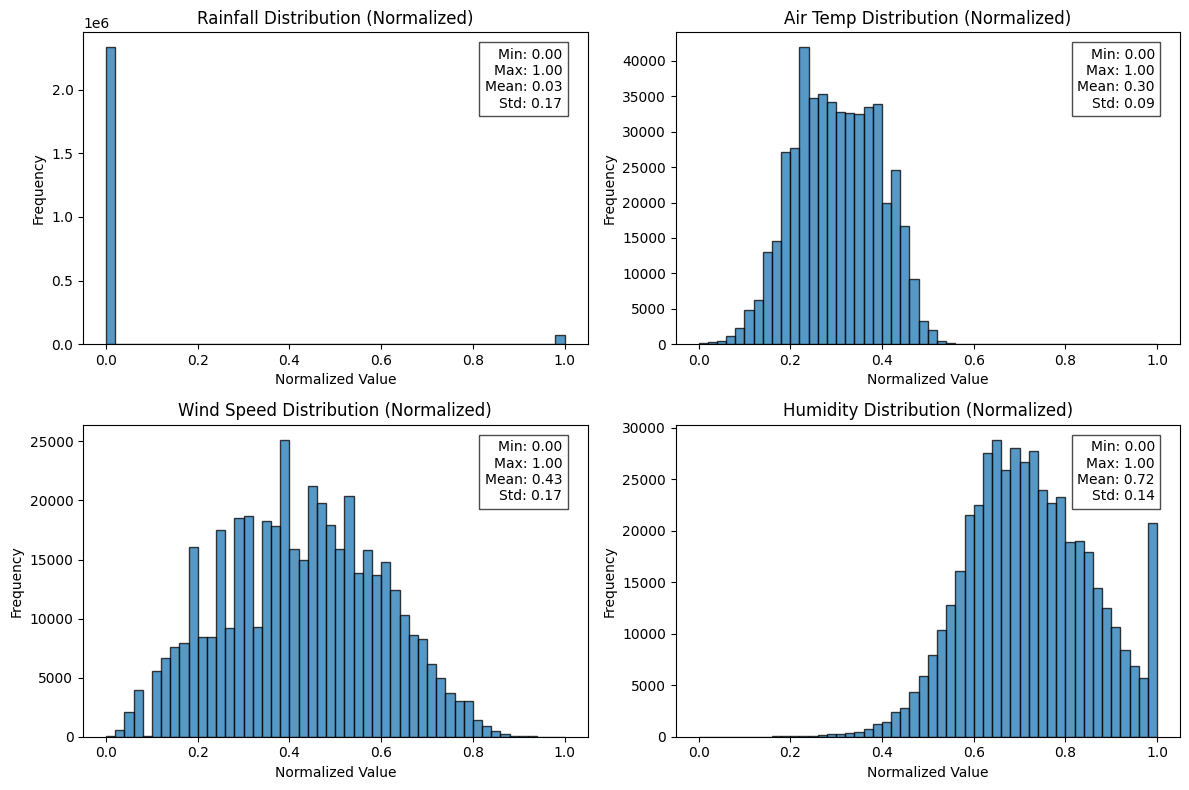

In [109]:
# List of dataframes
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity]
df_names = ["Rainfall", "Air Temp", "Wind Speed", "Humidity"]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten for easy iteration

for i, (df, name) in enumerate(zip(input_data_dfs, df_names)):
    # Select only numerical columns (excluding Timestamp)
    df_values = df.drop(columns=["Timestamp"], errors="ignore").melt().value.dropna()

    # Convert to float
    df_values = df_values.astype(float)

    # Apply Box-Cox if all values are positive; otherwise, use Yeo-Johnson
    if (df_values > 0).all():
        df_values, _ = boxcox(df_values + 1)  # Box-Cox requires strictly positive values
    else:
        transformer = PowerTransformer(method="yeo-johnson")
        df_values = transformer.fit_transform(df_values.to_numpy().reshape(-1, 1)).flatten()

    # Normalize using Min-Max Scaling
    scaler = MinMaxScaler()
    df_values = scaler.fit_transform(df_values.reshape(-1, 1)).flatten()

    # Calculate statistics
    min_val, max_val, mean_val, std_val = df_values.min(), df_values.max(), df_values.mean(), df_values.std()

    # Plot histogram
    axes[i].hist(df_values, bins=50, alpha=0.75, edgecolor="black")
    axes[i].set_title(f"{name} Distribution (Normalized)")
    axes[i].set_xlabel("Normalized Value")
    axes[i].set_ylabel("Frequency")

    # Show stats in the plot
    stats_text = f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}\nStd: {std_val:.2f}"
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show()


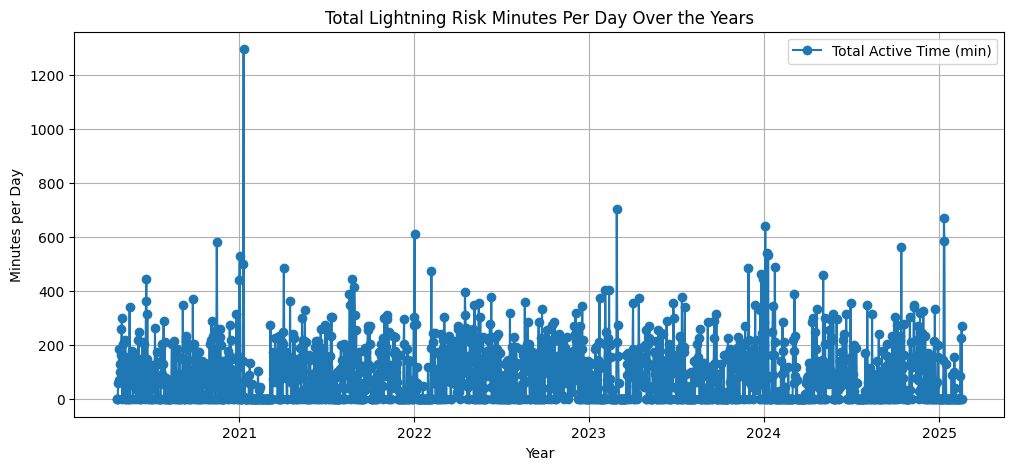

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
# Load the dataset
df["Timestamp"] = pd.to_datetime(lightning_risk_16S["Timestamp"])  # Convert to datetime
df["16S"] = lightning_risk_16S["16S"]
# Filter only 'True' values and group by Date
df["Minutes"] = df["16S"].astype(int) * 5  # Each 'True' is 5 min
daily_sums = df.groupby(df["Timestamp"].dt.date)["Minutes"].sum().reset_index()

# Convert back to datetime for proper plotting
daily_sums["Timestamp"] = pd.to_datetime(daily_sums["Timestamp"])

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(daily_sums["Timestamp"], daily_sums["Minutes"], marker="o", linestyle="-", label="Total Active Time (min)")
plt.xlabel("Year")
plt.ylabel("Minutes per Day")
plt.title("Total Lightning Risk Minutes Per Day Over the Years")
plt.legend()
plt.grid(True)
plt.show()


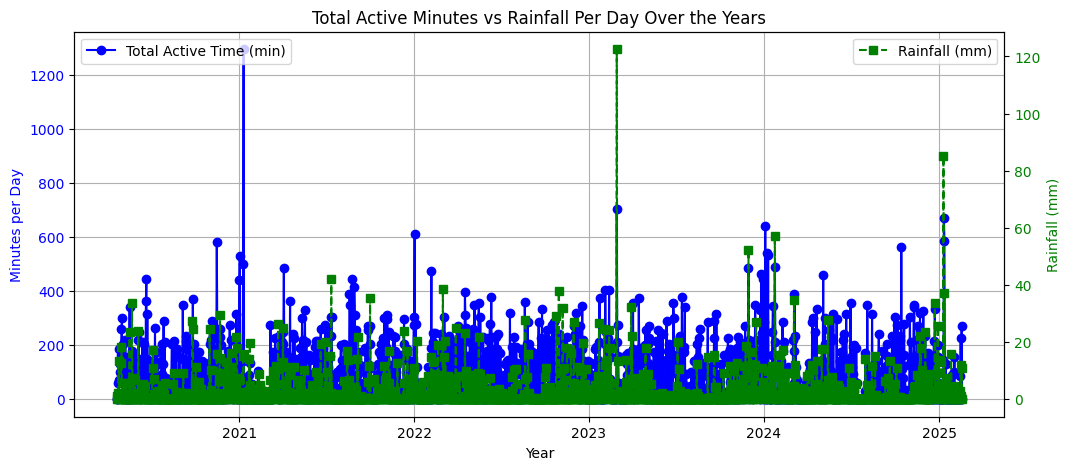

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Timestamp to datetime format
df = pd.DataFrame()
df["Timestamp"] = pd.to_datetime(lightning_risk_16S["Timestamp"])  
df["16S"] = lightning_risk_16S["16S"]
df["Minutes"] = df["16S"].astype(int) * 5  # Each 'True' is 5 min
daily_sums = df.groupby(df["Timestamp"].dt.date)["Minutes"].sum().reset_index()
daily_sums["Timestamp"] = pd.to_datetime(daily_sums["Timestamp"])  # Ensure proper datetime format

# Process Rainfall Data
# Convert Timestamp to datetime
rainfall["Timestamp"] = pd.to_datetime(rainfall["Timestamp"])
# Compute the average of all numerical columns (excluding Timestamp) per row
df2 = pd.DataFrame()
df2["Timestamp"] = rainfall["Timestamp"]
df2["RowAverage"] = rainfall.drop(columns=["Timestamp"], errors="ignore").mean(axis=1)
# Group by date and sum the RainfallAmount column
daily_rainfall = df2.groupby(df2["Timestamp"].dt.date)["RowAverage"].sum().reset_index()
daily_rainfall["Timestamp"] = pd.to_datetime(daily_rainfall["Timestamp"])

# Merge both datasets
merged_data = pd.merge(daily_sums, daily_rainfall, on="Timestamp", how="outer").fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot active minutes (left y-axis)
ax1.plot(merged_data["Timestamp"], merged_data["Minutes"], marker="o", linestyle="-", color="b", label="Total Active Time (min)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Minutes per Day", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.legend(loc="upper left")
ax1.grid(True)

# Add second y-axis for rainfall
ax2 = ax1.twinx()
ax2.plot(merged_data["Timestamp"], merged_data["RowAverage"], marker="s", linestyle="--", color="g", label="Rainfall (mm)")
ax2.set_ylabel("Rainfall (mm)", color="g")
ax2.tick_params(axis="y", labelcolor="g")
ax2.legend(loc="upper right")

plt.title("Total Active Minutes vs Rainfall Per Day Over the Years")
plt.show()


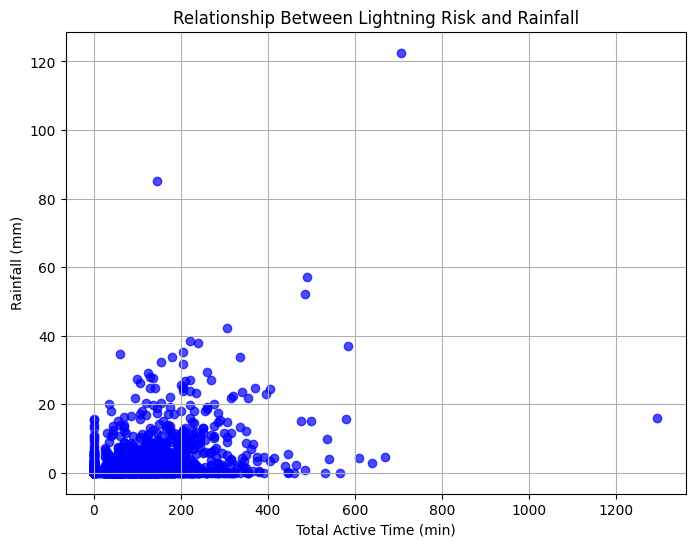

In [127]:
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_data["Minutes"], merged_data["RowAverage"], alpha=0.7, color="b")

# Labels and Title
plt.xlabel("Total Active Time (min)")
plt.ylabel("Rainfall (mm)")
plt.title("Relationship Between Lightning Risk and Rainfall")
plt.grid(True)

# Show Plot
plt.show()


No straightforward trend is observed.

In [128]:
def normalized_data(df):
    # Exclude "Timestamp" column (if present)
    df_numeric = df.drop(columns=["Timestamp"], errors="ignore").copy()

    # Convert to float
    df_numeric = df_numeric.astype(float)

    # Check if all values are positive for Box-Cox
    if (df_numeric > 0).all().all():  # Must be strictly positive
        df_transformed = df_numeric.apply(lambda col: boxcox(col + 1)[0] if col.min() > 0 else col, axis=0)
    else:
        transformer = PowerTransformer(method="yeo-johnson")
        df_transformed = pd.DataFrame(transformer.fit_transform(df_numeric), columns=df_numeric.columns)

    # Normalize to range 0-1
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_transformed), columns=df_numeric.columns)

    # Reattach "Timestamp" if it was removed
    if "Timestamp" in df.columns:
        df_normalized.insert(0, "Timestamp", df["Timestamp"])

    return df_normalized


In [129]:
rainfall_normalized = normalized_data(rainfall)
air_temperature_normalized  = normalized_data(air_temperature)
wind_speed_normalized  = normalized_data(wind_speed)
relative_humidity_normalized  = normalized_data(relative_humidity)

## Compiled Data

In [190]:
normalized_dfs = [rainfall_normalized, air_temperature_normalized, wind_speed_normalized, relative_humidity_normalized]
all_dfs = normalized_dfs + [lightning_risk_16S]

for i in range(len(all_dfs)):
    all_dfs[i]["Timestamp"]  = pd.to_datetime(all_dfs[i]["Timestamp"])
# Find the minimum and maximum timestamp across all datasets
min_timestamp = max(df["Timestamp"].min() for df in all_dfs)
max_timestamp = min(df["Timestamp"].max() for df in all_dfs)

print(f"Common Time Range: {min_timestamp} to {max_timestamp}")

# Filter each dataset to keep only the common time range
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][(all_dfs[i]["Timestamp"] >= min_timestamp) & 
                            (all_dfs[i]["Timestamp"] <= max_timestamp)]
# Merge the filtered datasets
compiled_dfs = []
for df, name in zip(normalized_dfs, ["Rainfall", "Air_Temp", "Wind_Speed", "Humidity"]):
    renamed_df = df.rename(columns={col: f"{name}_{col}" for col in station_ids})
    compiled_dfs.append(renamed_df)

# Merge all datasets on Timestamp
compiled_df = compiled_dfs[0]
for df in compiled_dfs[1:]:
    compiled_df = compiled_df.merge(df, on="Timestamp", how="outer")

# Merge lightning risk data
compiled_df = compiled_df.merge(lightning_risk_16S[["Timestamp", "16S"]], on="Timestamp", how="outer")
compiled_df = compiled_df.rename(columns={"16S": "Lightning_Risk"})
# Display final structure
compiled_df.head()


Common Time Range: 2020-04-20 22:20:00+08:00 to 2025-02-17 23:55:00+08:00


,Timestamp,Rainfall_S100,Rainfall_S104,Rainfall_S106,Rainfall_S107,Rainfall_S108,Rainfall_S109,Rainfall_S111,Rainfall_S115,Rainfall_S116,...,Humidity_S115,Humidity_S116,Humidity_S117,Humidity_S121,Humidity_S24,Humidity_S43,Humidity_S44,Humidity_S50,Humidity_S60,Lightning_Risk
0,2020-04-20 00:10:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2020-04-20 00:15:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2020-04-20 00:20:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2020-04-20 00:25:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2020-04-20 00:30:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [191]:
#compiled_df.to_csv("../data/final_data/Compiled Normalized Data.csv")

In [192]:
# Ensure 'Timestamp' is in datetime format
compiled_df["Timestamp"] = pd.to_datetime(compiled_df["Timestamp"])

# Set 'Timestamp' as the index if it is not already
if not isinstance(compiled_df.index, pd.DatetimeIndex):
    compiled_df.set_index("Timestamp", inplace=True)

# Now, make sure the index is timezone-naive
compiled_df.index = compiled_df.index.tz_localize(None)

# Get min and max timestamps rounded to 2-hour intervals
min_timestamp = compiled_df.index.min().ceil("2h") + pd.Timedelta(hours=2)
max_timestamp = compiled_df.index.max().floor("2h")

# Select timestamps that are within the range and are multiples of 2 hours
timestamps = compiled_df.loc[
    (compiled_df.index >= min_timestamp) & 
    (compiled_df.index <= max_timestamp) & 
    (compiled_df.index.hour % 2 == 0) & 
    (compiled_df.index.minute == 0)
].index

# Define the desired timezone
timezone = pytz.timezone("Asia/Singapore")  # UTC+08:00

# Convert timestamps to the required format
timestamps_str = [
    timestamp.tz_localize("UTC").tz_convert(timezone).strftime("%Y-%m-%d %H:%M:%S%z") 
    for timestamp in timestamps
]

# Replace `+0800` with `+08:00` for proper formatting
timestamps_str = [ts[:-2] + ":" + ts[-2:] for ts in timestamps_str]

# Prepare data storage
rows = {}
compiled_df_input = compiled_df.drop(columns=["Lightning_Risk"])  # Keep input features
input_columns = compiled_df_input.columns.values.tolist()

# Generate dataset with time shifts
for timestamp in timestamps:
    try:
        data = compiled_df_input.loc[
            [timestamp - pd.Timedelta(minutes=120),
             timestamp - pd.Timedelta(minutes=90),
             timestamp - pd.Timedelta(minutes=60),
             timestamp - pd.Timedelta(minutes=30),
             timestamp]
        ]
    except KeyError as e:
        print(f"Skipping timestamp {timestamp} due to missing data: {e}")
        continue  # Skip missing timestamps

    # Add lightning risk data
    try:
        lightning_data = compiled_df.loc[
            [timestamp, timestamp + pd.Timedelta(minutes=30),
             timestamp + pd.Timedelta(minutes=60),
             timestamp + pd.Timedelta(minutes=90),
             timestamp + pd.Timedelta(minutes=120)],
            "Lightning_Risk"
        ]
    except KeyError as e:
        print(f"Skipping timestamp {timestamp} due to missing lightning risk data: {e}")
        continue  # Skip missing timestamps

    rows[timestamp] = list(data.values.flatten()) + list(lightning_data.values.flatten())


# Define new column names
new_columns = [f"{col}{j}" for col in input_columns for j in ["-120", "-90", "-60", "-30", "-0"]]
new_columns += [f"16S{j}" for j in ["+0", "+30", "+60", "+90", "+120"]]

# Convert to DataFrame
compiled_data = pd.DataFrame.from_dict(rows, orient="index", columns=new_columns)
compiled_data.index.name = "Timestamp"

# Display results
print(compiled_data.head())

Skipping timestamp 2025-02-18 08:00:00 due to missing lightning risk data: "[Timestamp('2025-02-18 09:00:00'), Timestamp('2025-02-18 09:30:00'), Timestamp('2025-02-18 10:00:00')] not in index"
                     Rainfall_S100-120  Rainfall_S100-90  Rainfall_S100-60  \
Timestamp                                                                    
2020-04-20 04:00:00                NaN               NaN               NaN   
2020-04-20 06:00:00                NaN               NaN               NaN   
2020-04-20 08:00:00                NaN               NaN               NaN   
2020-04-20 10:00:00                NaN               NaN               NaN   
2020-04-20 12:00:00                NaN               NaN               NaN   

                     Rainfall_S100-30  Rainfall_S100-0  Rainfall_S104-120  \
Timestamp                                                                   
2020-04-20 04:00:00               NaN              NaN                NaN   
2020-04-20 06:00:00          

In [193]:
compiled_data.to_csv("../data/final_data/Complete Data.csv")

Check any missing data points from

In [194]:
af = pd.DataFrame()

timezone = pytz.timezone("Asia/Singapore")  # UTC+08:00
min_timestamp_8 = min_timestamp.tz_localize("UTC").tz_convert(timezone).strftime("%Y-%m-%d %H:%M:%S%z") 
# Replace `+0800` with `+08:00` for proper formatting
min_timestamp_8 = min_timestamp_8[:-2] + ":" + min_timestamp_8[-2:]
max_timestamp_8 = max_timestamp.tz_localize("UTC").tz_convert(timezone).strftime("%Y-%m-%d %H:%M:%S%z") 
# Replace `+0800` with `+08:00` for proper formatting
max_timestamp_8 = max_timestamp_8[:-2] + ":" + max_timestamp_8[-2:]
af = lightning_risk_16S[(lightning_risk_16S["Timestamp"] <= max_timestamp_8) & (lightning_risk_16S["Timestamp"] >= min_timestamp_8)]
af.set_index("Timestamp", inplace=True)
af.index = af.index.tz_localize(None)

In [195]:
# Get the indexes of both DataFrames
index_1 = set(compiled_df.index)
index_2 = set(af.index)

# Find indexes that are in one DataFrame but not the other
different_indexes = index_1.symmetric_difference(index_2)

print(different_indexes)

{Timestamp('2020-04-20 09:20:00'), Timestamp('2020-04-20 11:00:00'), Timestamp('2020-04-20 07:15:00'), Timestamp('2020-04-20 08:00:00'), Timestamp('2020-04-20 01:35:00'), Timestamp('2020-04-20 06:15:00'), Timestamp('2020-04-20 08:25:00'), Timestamp('2020-04-20 02:45:00'), Timestamp('2020-04-20 07:20:00'), Timestamp('2020-04-20 10:35:00'), Timestamp('2020-04-20 10:55:00'), Timestamp('2020-04-20 11:25:00'), Timestamp('2020-04-20 10:40:00'), Timestamp('2020-04-20 11:45:00'), Timestamp('2020-04-20 11:50:00'), Timestamp('2020-04-20 06:40:00'), Timestamp('2020-04-20 03:55:00'), Timestamp('2020-04-20 03:25:00'), Timestamp('2020-04-20 04:55:00'), Timestamp('2020-04-20 01:10:00'), Timestamp('2020-04-20 01:20:00'), Timestamp('2020-04-20 01:45:00'), Timestamp('2020-04-20 00:20:00'), Timestamp('2020-04-20 01:05:00'), Timestamp('2020-04-20 06:45:00'), Timestamp('2020-04-20 07:40:00'), Timestamp('2020-04-20 09:45:00'), Timestamp('2020-04-20 01:00:00'), Timestamp('2020-04-20 10:30:00'), Timestamp('20

In [196]:
print(len(different_indexes), min_timestamp, max_timestamp)

142 2020-04-20 04:00:00 2025-02-18 08:00:00
